# 08_Simple-MLP-unsupervised

Extend the original simple MLP pruning model but change the output task to a self-supervised task.

Clustering like in DrLIM with contrastive loss (Hadsell et. al. 2005)
- The goal was to make a better clustering algorithm
- Use prior knowledge put similar points together vs others
- Trained a siamese network: same network applied on two different data points. Then take the distance of resulting embeddings. Use this distance to calculate the loss.

- They used a CNN. Any idea if this can work on an MLP?

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from src.simple_pruning_growth_model import DrLIMPruneGrowNetwork, ContrastiveLoss, constrative_test_loop
from src.training_testing_loop import full_train, save_model_attr, format_training_outputs
from src.load_MNIST import get_mnist_pairs_loader
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

For now, directly use the labels to make the pairs. Next, implement pairs that is label agnostic via simple eucledian distance and creating a neighborhood graph

In [64]:
train_pair_dataloader, val_pair_dataloader = get_mnist_pairs_loader(batch_size=32, train=True, subset_fraction=0.01, validation_ratio=6)

In [65]:
test_pair_dataloader = get_mnist_pairs_loader(batch_size=32, train=False, subset_fraction=0.01)

In [69]:
DrLIM_model = DrLIMPruneGrowNetwork(
    gamma=0.1, init_density=0.5, num_training_iter=5,
    low_mapping_dim=2,
)

contrastive_loss_fn = ContrastiveLoss()
val_contrastive_loss_fn = ContrastiveLoss(reduction='sum')

train_losses_epoch, val_losses_epoch, test_df = full_train(
    DrLIM_model, train_pair_dataloader, val_pair_dataloader, test_pair_dataloader,
    learning_rate = 1e-2, 
    loss_fn=contrastive_loss_fn,
    val_loss_fn=val_contrastive_loss_fn,
    plot=False, verbose=False,
    test_loop_func=constrative_test_loop,
    margin=contrastive_loss_fn.m,
    args_expand=True,
)

Epochs:  20%|███████████████████████                                                                                            | 1/5 [00:22<01:28, 22.07s/it]

109


Epochs:  40%|██████████████████████████████████████████████                                                                     | 2/5 [00:45<01:07, 22.63s/it]

107


Epochs:  60%|█████████████████████████████████████████████████████████████████████                                              | 3/5 [01:06<00:44, 22.17s/it]

109


Epochs:  80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 4/5 [01:30<00:22, 22.69s/it]

111


Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:53<00:00, 22.71s/it]

111


In [70]:
stack_training_losses_df, stack_val_losses_df = format_training_outputs(train_losses_epoch, val_losses_epoch)

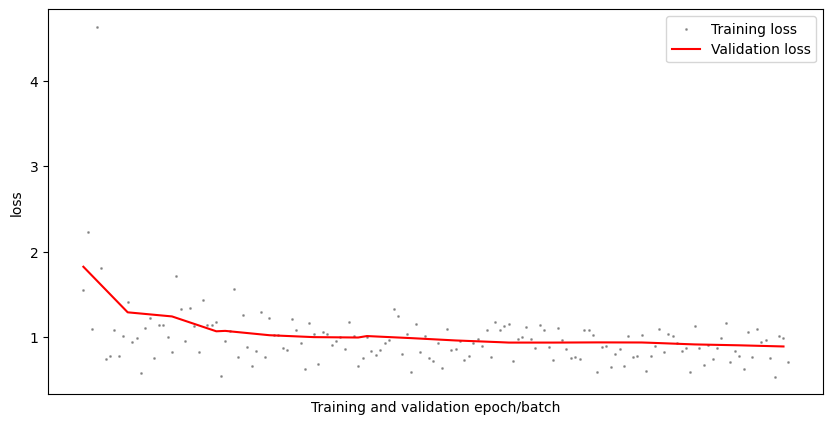

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(stack_training_losses_df.reset_index(), x='index', y='loss', label='Training loss', alpha=1.0, c='gray', s=4, ax=ax)
sns.lineplot(stack_val_losses_df.reset_index(), x='index', y='loss',  label='Validation loss', c='red', ax=ax)
plt.xticks([])
plt.xlabel('Training and validation epoch/batch')
plt.show()

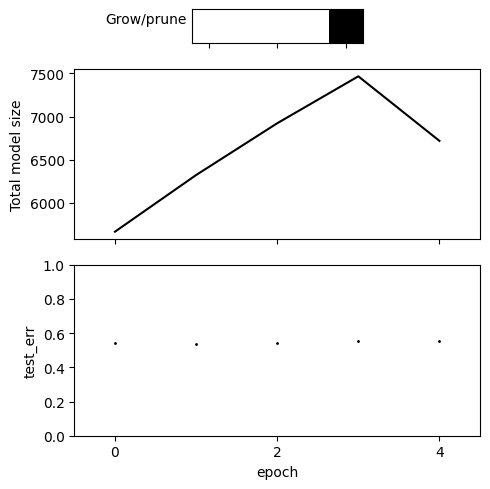

In [72]:
fig, axes = plt.subplots(3, 1, figsize=(5, 5), sharex=True, height_ratios=[1, 5, 5])
axes[0].imshow(np.array(np.array(DrLIM_model.grow_prune_history).reshape(1, -1)), cmap='gray')
axes[0].set_yticks([])
axes[0].set_ylabel("Grow/prune", rotation=0, ha='right')

axes[1].plot(DrLIM_model.synapse_count_history, c='k') 
axes[1].set_ylabel("Total model size")

sns.scatterplot(test_df.reset_index(), x='epoch', y='test_err', ax=axes[2], c='k', s=5) 
axes[2].set_ylim(0, 1.0)
plt.tight_layout()
plt.show()


In [73]:
DrLIM_model.total_size

12576

In [74]:
test_df

,test_err,test_loss
epoch,,
0,0.545,1.196777
1,0.535,1.317497
2,0.545,1.272551
3,0.555,1.067838
4,0.555,1.124896


In [75]:
DrLIM_model.grow_prune_history

[1, 1, 1, 1, 0]

In [76]:
DrLIM_model.grow_prob_history

[1.0, 0.8, 0.6000000000000001, 0.4000000000000001, 0.20000000000000007]

In [80]:
pred[0].shape

torch.Size([32, 2])

In [82]:
pred[1]

tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [2.3901, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 1.7060],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.7397, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0740, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.1866],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 2.1109],
        [0.0000, 0.0000],
        [0.0000, 0.9440],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000]])

In [84]:
DrLIM_model.eval()
colors = {1: 'red', 0: 'k'}
with torch.no_grad():
    for X, y in train_pair_dataloader:
        pred = DrLIM_model(X)
        plt.scatter(pred[0][:, 0], pred[0][:, 1], c=colors[y])
        plt.scatter(pred[1][:, 0], pred[1][:, 1], c=colors[y])
        plt.show()
        assert False
        break

KeyError: tensor([0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1.])

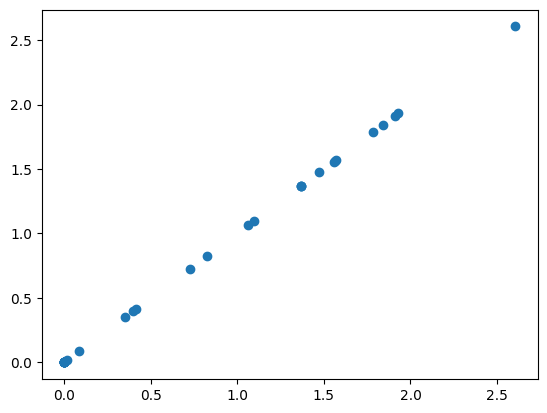

In [53]:
plt.scatter(pred[0][:, 0], pred[0][:, 0])
plt.show()